## First loading in modules

In [1]:
from masking_py3 import maskmaker
import numpy as np
import matplotlib.pyplot as plt
from psana import * 

# This first section creates a basic mask using a dark and a blank run

## Defining the tunables

In [ ]:
run = 44
Nevents = 100000
datadir = '/sdf/data/lcls/ds/cxi/cxil1015022/scratch/nag1647/Masks/'
detector = 'front' 
filename = datadir+'run%d_%d_stats.h5' %(run, Nevents/1000)
#whichmask = 'dark' #'dark' or 'xray'
whichmask = 'xray'

if whichmask == 'xray':
	oldmask = np.load(datadir+'run%d_mask_dark.npy' %run)
#    oldmask = np.load(datadir+'Mask_Jungfrau_T_Edge_Corrected.npy')
if whichmask == 'dark':
	oldmask = np.load(datadir+'Mask_Jungfrau_Line_Edge.npy') #mask of just edge & unbonded pixels
    


## Make the Mask

In [ ]:
#maskmaker makes the mask, starting from the 'oldmask' input
mm = maskmaker('cxil1015022', run, detector, filename, oldmask)

xray_image = np.copy(mm.xray)
dark_image = np.copy(mm.dark)

## Find Upper and Lower Bounds

In [ ]:
###### print 'use the histogram to find lower and upper bounds'
if whichmask == 'xray':
	plt.hist(xray_image.flatten(), bins=552, range = (-.15, .15))
	plt.title('xray-on image')
if whichmask == 'dark':
	plt.hist(dark_image.flatten(), bins=100, range = (-.25,.25))
	plt.title('xray-off image run %d' % run)
plt.ylabel('pixel counts')
plt.xlabel('ADU per pixel')
plt.show()
#plt.savefig('run%d_dark.png' % run)

print('input the lower bound:')
lb = float(input())
print('input the upper bound:')
ub = float(input())

assert ub > lb

## Make new mask

In [ ]:
name = datadir+'run%d_mask_%s.npy' %(run, whichmask)
newmask = mm(whichmask, lowerbound=lb, upperbound=ub, tolerance=2.5, name=name)
print(newmask.sum())

# Next making a mask to match SF6 Experiment to Theory

## First combining the blank and dark mask into the final basic mask

In [2]:
datadir = '/sdf/data/lcls/ds/cxi/cxil1015022/scratch/nag1647/Masks/'
dark_run = 174
blank_run = 175

mask_off = np.load(datadir+'run%d_mask_xray.npy' % dark_run)
mask_on = np.load(datadir+'run%d_mask_xray.npy' % blank_run) 

mask_tot = mask_off*mask_on
print(100*np.sum(mask_tot)/mask_tot.size) #Percentage of pixels currently making it through the mask

94.53585147857666


## Set the tunables

In [3]:
run = 180
Nevents = 100000
filename = datadir+'run%d_%d_stats.h5' %(run, Nevents/1000)
whichmask = 'SF6'

x0 = -734.66
y0 = -213.26
z0 = 84160. 
xrayEnergy = 9800. #Xray photon energy in eV 
qbinsize = 0.2 #inverse Angstroms

In [4]:
import h5py

hf = h5py.File(filename, 'r')
for item in hf:
    print(item)
    exec('%s = np.array(hf[item])' %str(item))
print(xray_shots)

dark_front
dark_shots
front_intensity
xray_front
xray_shots
35536


## Finding lower and upper bounds and creating mask.  Go through this module once for each qbin, from Index = 0 to Index = len(qbins)

dark_front
dark_shots
front_intensity
xray_front
xray_shots
22


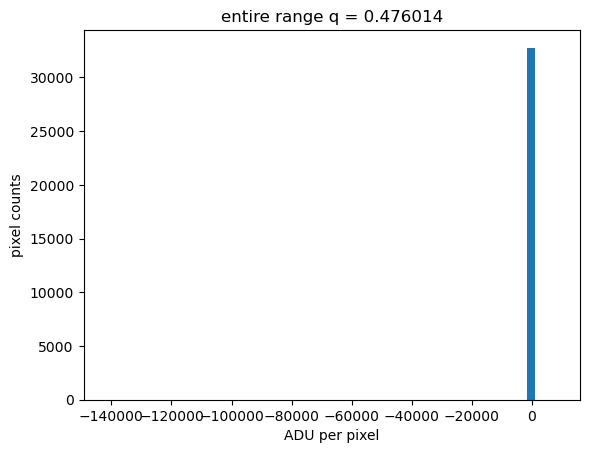

<Figure size 640x480 with 0 Axes>

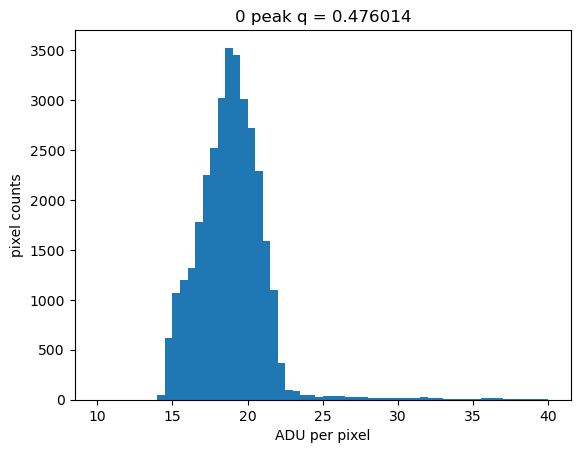

ADU ranges ok? Answer yes or no


 yes


input the lower bound for signal peak:


 13


input the upper bound for signal peak:


 40


97.44782447814941


In [8]:
###### print 'use the histogram to find lower and upper bounds'
from masking_SF6_py3 import maskmaker_SF6
line_mask = np.load('/sdf/data/lcls/ds/cxi/cxil1015022/scratch/nag1647/Masks/line_mask.npy')
index = 1
if index == 0:
    #oldmask = mask_tot
    oldmask = line_mask
elif index != 0:
    oldmask = np.load(datadir+'run%d_mask_%s.npy' %(run, whichmask))
mmSF6 = maskmaker_SF6('cxil1015022', run, filename, oldmask, x0, y0, z0, xrayEnergy, qbinsize)
xray_image = np.copy(mmSF6.xray)
dark_image = np.copy(mmSF6.dark)
q = np.copy(mmSF6.q)
qbins = np.copy(mmSF6.qbins)
print(len(qbins))
inds = np.where((q>=qbins[index])&(q<qbins[index+1]))
qring = xray_image[inds]
plt.figure()
plt.hist(qring.flatten(), bins=60)
plt.title('entire range q = %3f' % qbins[index])
plt.ylabel('pixel counts')
plt.xlabel('ADU per pixel')
plt.show()
plt.figure()
plt.figure()
plt.hist(qring.flatten(), bins=60, range = (10,40))
plt.title('0 peak q = %3f' % qbins[index])
plt.ylabel('pixel counts')
plt.xlabel('ADU per pixel')
plt.show()

print('ADU ranges ok? Answer yes or no')
answer = str(input())
if answer == 'yes':
    print('input the lower bound for signal peak:')
    lb1 = float(input())
    print('input the upper bound for signal peak:')
    ub1 = float(input())
    assert ub1 > lb1
    name = datadir+'run%d_mask_%s.npy' %(run, whichmask)
#    newmask = mmSF6(whichmask, lowerbound=lb, upperbound=ub, upperbound_signal = ub1, lowerbound_signal = lb1, name=name, inds=inds)
    newmask = mmSF6(whichmask, upperbound_signal = ub1, lowerbound_signal = lb1, name=name, inds=inds)
    print(100*newmask.sum()/newmask.size)
elif answer != 'yes':
    print('Adjust the ranges and try again.  Answer yes when they are good')

## Once each qbin has been masked, run this final module to save the result

In [11]:
print(100*np.sum(oldmask/(8*512*1024)))

97.44977951049805


In [14]:
datadir = '/sdf/data/lcls/ds/cxi/cxil1015022/scratch/nag1647/Masks/'
dark_run = 174
blank_run = 175
SF6_run = 180

mask = np.load(datadir+'run%d_mask_SF6.npy' % SF6_run)

#np.save(datadir+'Mask_Jungfrau_%d_%d_%d_SF6_Tuned_strict.npy' %(dark_run, blank_run, SF6_run), mask)
np.save(datadir+'Mask_Jungfrau_Shadow.npy', mask)
print(100*np.sum(mask)/mask.size) #Percentage of pixels currently making it through the mask

97.44782447814941


# Plotting Section

## Show Xray On Jungfrau Image

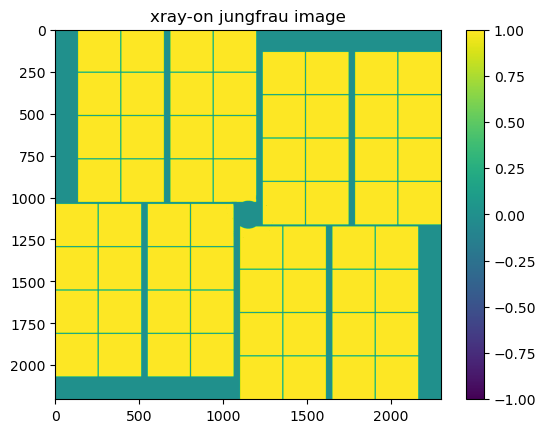

In [9]:
img = mmSF6.det.image(mmSF6.evt0, newmask)
plt.imshow(img, vmin=-1, vmax=1)
plt.colorbar()
plt.title('xray-on jungfrau image')
plt.show()

In [ ]:
img = mm.det.image(mm.evt0, xray_image)
plt.imshow(img, vmin=lb, vmax=ub)
plt.colorbar()
plt.title('xray-on jungfrau image')
plt.show()

## Show Dark Image

In [ ]:
img = mm.det.image(mm.evt0, dark_image)
plt.imshow(img, vmin=-2, vmax=2)
plt.title('dark jungfrau image')
plt.colorbar()
plt.show()

## Show Masked Image

In [ ]:
img = mm.det.image(mm.evt0, newmask* xray_image)
plt.imshow(img, vmin=lb, vmax=ub)
plt.title('dark jungfrau image')
plt.colorbar()
plt.title('masked jungfrau')
plt.show()

In [ ]:
img = mm.det.image(mm.evt0, oldmask)
plt.imshow(img, vmin=0, vmax=1.3, cmap = 'jet')
plt.title('Basic Mask')
plt.colorbar()
plt.show()
#plt.savefig('analysis_mask.png')